In [1]:
import itertools
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import pdb

In [2]:
data = pd.read_csv('case_8.csv')
## test the code with a subset of the data
#data = data[0:1000]
target = data['target']
data.drop(['target', 'ID'],inplace=True, axis=1)

In [3]:
### Find cols with over 10 categories 
cat_data = data.loc[:, data.dtypes == object]

col_bin_candidates = dict()
for col in cat_data:
    category_count = len(data[col].value_counts())
    if category_count > 20:
        col_bin_candidates[col] = category_count
        
col_bin_candidates

{'v22': 18210, 'v56': 122, 'v112': 22, 'v113': 36, 'v125': 90}

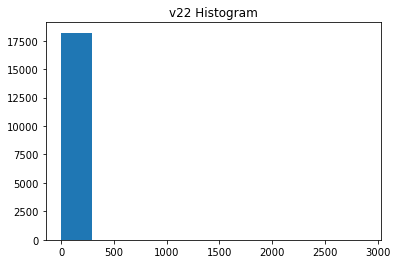

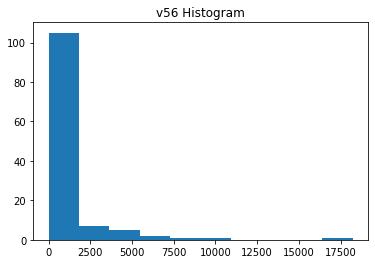

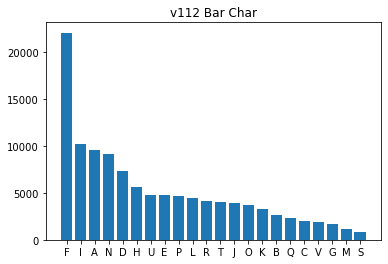

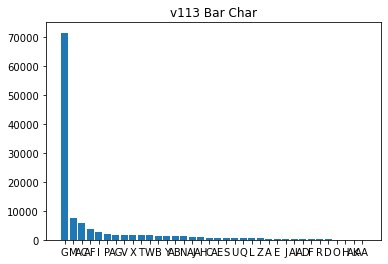

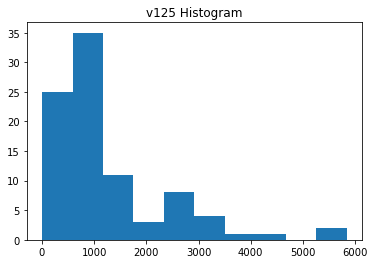

In [4]:
### Visualized values for cols with over 10 categories
for col in col_bin_candidates:
    counts = data[col].value_counts().to_frame()
    
    fig = plt.figure()
    if len(counts) < 50:
        plt.title("{c} Bar Char".format(c=col)) 
        plt.bar(counts.index, counts[col])
    else:
        plt.title("{c} Histogram".format(c=col)) 
        plt.hist(counts[col])

In [5]:
### Look for bin point col v22
data['v22'].value_counts()[0:50]

AGDF    2886
YGJ     2119
QKI      668
PWR      649
HZE      423
MNZ      382
PTO      350
ROZ      344
YOD      303
GBS      299
VZF      296
AJQ      252
WNI      244
HDD      243
NRT      238
PFR      226
YEP      224
ADDF     212
VVI      211
QVR      210
WRI      207
ABOF     204
PSE      199
NGS      197
ACWE     190
TVR      182
PTJ      178
ADMP     172
UAG      169
NWG      167
AGON     167
AHE      167
ABF      166
TG       166
EJC      165
AAPP     164
OFD      161
AMR      160
AFYU     159
ADMI     156
AFOZ     152
PBC      152
DJU      152
GEJ      150
AXH      148
QKP      147
RIC      146
MQE      146
HUU      146
JGY      138
Name: v22, dtype: int64

In [6]:
### Look for bin point col v56
data['v56'].value_counts()[0:50]

BW    18233
DI    10256
AS     8832
BZ     7174
AW     6369
DO     5289
P      4997
DP     4647
CY     3830
CN     3745
BL     3570
AF     2355
BJ     2345
AG     2164
DX     2095
DY     1971
BV     1899
U      1675
DJ     1660
N      1638
DS     1513
V      1477
BX     1387
DH     1298
DF     1119
AL      966
DR      932
BK      921
BM      877
G       770
CS      698
DA      694
BQ      616
CP      598
R       595
AZ      397
BA      394
CM      393
AI      323
Y       314
AR      260
CI      222
AO      211
Z       199
A       186
AN      178
CC      153
CF      141
BH      118
DL      117
Name: v56, dtype: int64

In [7]:
#### Bin categorical colunm based on cutoff for minmum value count
def bin_df_col(df, col, cutoff):
    vc = df[col].value_counts().to_frame()
    below_cutoff = vc[vc[col] < cutoff].index
    df.loc[(df[col].isin(below_cutoff)), col] = 'Other'
    
    return df

In [8]:
### Bin cols based on observations above
data = bin_df_col(data, 'v22', 140)
data = bin_df_col(data, 'v56', 140)

In [9]:
### One hot encode
data_ohe = pd.get_dummies(data)
data_ohe.shape

In [28]:
def run_clf(a_clf, data, clf_hyper):
    M, L, n_folds = data # unpack data container
    kf = KFold(n_splits=n_folds) # Establish the cross validation
    scores = []

    for ids, (train_index, test_index) in enumerate(kf.split(M, L)):
        clf = a_clf(**clf_hyper) # unpack parameters into clf is they exist
        clf.fit(M.iloc[train_index], L.iloc[train_index])

        pred = clf.predict(M.iloc[test_index])
        score = log_loss(L.iloc[test_index], pred)
        scores.append(score)

    ret = {
        'clf': str(clf),
        'score': sum(scores) / float(len(scores))
    }

    return ret

In [30]:
def run_xgb(data, clf_hyper, boost_round):
    M, L, n_folds = data # unpack data container
    kf = KFold(n_splits=n_folds) # Establish the cross validation
    scores = []

    for ids, (train_index, test_index) in enumerate(kf.split(M, L)):
        xgtrain = xgb.DMatrix(M.iloc[train_index].values, L.iloc[train_index].values)
        xgtest = xgb.DMatrix(M.iloc[test_index].values, L.iloc[test_index].values)
        
        clf = xgb.train(
            clf_hyper,
            xgtrain,
            num_boost_round=boost_round,
            verbose_eval=True,
            maximize=False
        )
        
        pred = clf.predict(xgtest, ntree_limit=clf.best_iteration)
        score = log_loss(L.iloc[test_index], pred)
        scores.append(score)

    ret = {
        'params': clf_hyper,
        'boost_round': boost_round,
        'score': sum(scores) / float(len(scores))
    }

    return ret

In [31]:
def run_clf_grid(data, clf_hyper_grid, return_best=False, boost_rounds=None, clf=None):
    clf_scores = []

    param, param_values = zip(*clf_hyper_grid.items())
    param_list = [dict(zip(param, param_value)) for param_value in itertools.product(*param_values)]

    for params in param_list:
        if clf:
            score = run_clf(clf, data, params)
            clf_scores.append(score)
        else:
            for boost_round in boost_rounds:
                score = run_xgb(data, params, boost_round)
                clf_scores.append(score)

    clf_scores.sort(key=lambda x: x['score'])
    if return_best:
        clf_scores = [clf_scores[0]]

    return clf_scores

In [32]:
xgboost_hyper = { 
   "objective": ["binary:logistic"],
   "booster": ["gbtree"],
   "eval_metric": ["logloss"],
   "eta": [0.001, 0.01, 0.1], 
   "subsample": [.25, .5],
   "colsample_bytree": [0.25, 0.5],
   "max_depth": [2,4]
}
clf_data = (data_ohe, target, 3)
xgb_scores = run_clf_grid(clf_data, xgboost_hyper, boost_rounds=[30,60])

In [33]:
xgb_scores

[{'params': {'objective': 'binary:logistic',
   'booster': 'gbtree',
   'eval_metric': 'logloss',
   'eta': 0.1,
   'subsample': 0.5,
   'colsample_bytree': 0.5,
   'max_depth': 4},
  'boost_round': 60,
  'score': 0.4731069732370199},
 {'params': {'objective': 'binary:logistic',
   'booster': 'gbtree',
   'eval_metric': 'logloss',
   'eta': 0.1,
   'subsample': 0.25,
   'colsample_bytree': 0.5,
   'max_depth': 4},
  'boost_round': 60,
  'score': 0.47504445392428885},
 {'params': {'objective': 'binary:logistic',
   'booster': 'gbtree',
   'eval_metric': 'logloss',
   'eta': 0.1,
   'subsample': 0.5,
   'colsample_bytree': 0.25,
   'max_depth': 4},
  'boost_round': 60,
  'score': 0.47655808016394663},
 {'params': {'objective': 'binary:logistic',
   'booster': 'gbtree',
   'eval_metric': 'logloss',
   'eta': 0.1,
   'subsample': 0.25,
   'colsample_bytree': 0.25,
   'max_depth': 4},
  'boost_round': 60,
  'score': 0.4787245232475293},
 {'params': {'objective': 'binary:logistic',
   'boost

In [35]:
r_clf = RandomForestClassifier
r_clf_hyper_grid = {
'n_estimators': [10, 100],
'max_depth': [2, 4],
'max_features': [None, 'sqrt'],
}
rf_scores = run_clf_grid(clf_data, r_clf_hyper_grid, clf=r_clf)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_ohe, target, test_size=0.33, random_state=42)
xgtrain = xgb.DMatrix(X_train.values, y_train.values)
xgtest = xgb.DMatrix(X_test.values, y_test.values)

In [18]:
print('Fit the model...')
# XGBoost params:
xgboost_params = { 
   "objective": "binary:logistic",
   "booster": "gbtree",
   "eval_metric": "logloss",
   "eta": 0.01, 
   "subsample": 0.5,
   "colsample_bytree": 0.5,
   "max_depth": 3
}
boost_round = 50
clf = xgb.train(xgboost_params,xgtrain,num_boost_round=boost_round,verbose_eval=True,maximize=False)

Fit the model...


In [19]:
#Make predict
print('Predict...')
test_preds = clf.predict(xgtest, ntree_limit=clf.best_iteration)
print(log_loss(y_test,test_preds))
print(accuracy_score(y_test,np.rint(test_preds)))

Predict...
0.5840175097972852
0.7726501616922017
